In [ ]:
!gdown --id 157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
!unzip -q LOLdataset.zip -d /content/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
From (redirected): https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB&confirm=t&uuid=64e025c4-7424-4f4f-9229-e10bd28538c6
To: /content/LOLdataset.zip
100% 347M/347M [00:03<00:00, 91.3MB/s]


In [ ]:
# Install required packages (uncomment if running in a new environment)
!pip install PyWavelets scikit-image opencv-python tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.9 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from skimage.restoration import denoise_wavelet
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Define paths
TRAIN_LOW_PATH = "/content/our485/low"
TRAIN_HIGH_PATH = "/content/our485/high"
TEST_LOW_PATH = "/content/eval15/low"
TEST_HIGH_PATH = "/content/eval15/high"

# Define the hybrid LeNet-U-Net model
def hybrid_lenet_unet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder (LeNet-5 inspired)
    # Block 1
    c1 = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (5, 5), activation='relu', padding='same')(c1)
    p1 = AveragePooling2D((2, 2))(c1)  # 128x128

    # Block 2
    c2 = Conv2D(64, (5, 5), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (5, 5), activation='relu', padding='same')(c2)
    p2 = AveragePooling2D((2, 2))(c2)  # 64x64

    # Block 3 (Bottleneck)
    c3 = Conv2D(128, (5, 5), activation='relu', padding='same')(p2)
    p3 = AveragePooling2D((2, 2))(c3)  # 32x32

    # Decoder (U-Net inspired)
    # Upsample + skip connections
    u1 = UpSampling2D((2, 2))(p3)  # 64x64
    u1 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    # Adjust channels and spatial dimensions for skip connection
    c2_resized = AveragePooling2D((2, 2))(c2)  # Downsample c2 from 128x128 to 64x64
    c2_resized = Conv2D(128, (1, 1), activation='relu', padding='same')(c2_resized)
    m1 = Concatenate()([u1, c2_resized])  # Both are 64x64x128

    u2 = UpSampling2D((2, 2))(m1)  # 128x128
    u2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    # Adjust channels and spatial dimensions for skip connection
    c1_resized = AveragePooling2D((2, 2))(c1)  # Downsample c1 from 256x256 to 128x128
    c1_resized = Conv2D(64, (1, 1), activation='relu', padding='same')(c1_resized)
    m2 = Concatenate()([u2, c1_resized])  # Both are 128x128x64

    u3 = UpSampling2D((2, 2))(m2)  # 256x256
    u3 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)

    # Output
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(u3)

    return Model(inputs, outputs)

# Hybrid loss function (SSIM + L1)
def hybrid_loss(y_true, y_pred):
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    l1_loss = tf.reduce_mean(tf.abs(y_true - y_pred))
    return ssim_loss + 0.5 * l1_loss

# Data loading and preprocessing
def load_images(folder_path, img_size=(256, 256), denoise=True):
    images = []
    valid_extensions = ('.png', '.jpg', '.jpeg')

    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(valid_extensions):
            print(f"Skipping non-image file: {filename}")
            continue

        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype(np.float32) / 255.0  # Normalize to [0,1]

        if denoise:
            try:
                img = denoise_wavelet(img, channel_axis=-1, rescale_sigma=True)
            except Exception as e:
                print(f"Wavelet denoising failed for {img_path}: {str(e)}")

        images.append(img)

    return np.array(images)

# Load dataset
print("Loading training data...")
train_low = load_images(TRAIN_LOW_PATH)
train_high = load_images(TRAIN_HIGH_PATH, denoise=False)

print("Loading test data...")
test_low = load_images(TEST_LOW_PATH)
test_high = load_images(TEST_HIGH_PATH, denoise=False)

# Verify dataset sizes
print(f"Train low-light images: {len(train_low)}")
print(f"Train high-light images: {len(train_high)}")
print(f"Test low-light images: {len(test_low)}")
print(f"Test high-light images: {len(test_high)}")

# Initialize and compile model
print("Building model...")
model = hybrid_lenet_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=hybrid_loss,
              metrics=['accuracy'])

# Train the model
print("Training model...")
history = model.fit(
    train_low, train_high,
    validation_data=(test_low, test_high),
    epochs=50,
    batch_size=8,
    verbose=1
)

# Visualization function
def plot_results(low, enhanced, ground_truth):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(low)
    plt.title("Low-Light Input")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(enhanced)
    plt.title("Enhanced Output")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(f'enhanced_image_{np.random.randint(10000)}.png')  # Save instead of show
    plt.close()

# Test the model
print("Testing model...")
for i in range(min(3, len(test_low))):  # Show up to 3 test images
    low = test_low[i:i+1]
    enhanced = model.predict(low, verbose=0)
    plot_results(low[0], enhanced[0], test_high[i])

# Save the model
model.save("hybrid_lenet_unet_lowlight.h5")
print("Model saved successfully!")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

Loading training data...
Skipping non-image file: .DS_Store
Skipping non-image file: .DS_Store
Loading test data...
Train low-light images: 485
Train high-light images: 485
Test low-light images: 15
Test high-light images: 15
Building model...
Training model...
Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 56s 530ms/step - accuracy: 0.4546 - loss: 0.4935 - val_accuracy: 0.4805 - val_loss: 0.3505
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.5414 - loss: 0.3168 - val_accuracy: 0.6993 - val_loss: 0.3171
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.6057 - loss: 0.3029 - val_accuracy: 0.6656 - val_loss: 0.3105
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.6658 - loss: 0.2855 - val_accuracy: 0.5333 - val_loss: 0.3135
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.6811 - loss: 0.2749 - val_accuracy: 0.7606 - val_loss: 0.2972
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 0.6888 - loss: 0.2624 - val_a

Model saved successfully!


5-5 Epoch Model Training

In [ ]:
# Import additional libraries
import time
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse

# Define paths
MODEL_SAVE_PATH = "/content/drive/MyDrive/Model"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Metrics computation function
def compute_metrics(enhanced, ground_truth):
    enhanced = np.clip(enhanced, 0, 1)
    ground_truth = np.clip(ground_truth, 0, 1)
    psnr_val = psnr(ground_truth, enhanced, data_range=1.0)
    ssim_val = ssim(ground_truth, enhanced, data_range=1.0, channel_axis=-1)
    mse_val = mse(ground_truth.flatten(), enhanced.flatten())
    return psnr_val, ssim_val, mse_val

# Modified training loop with model saving and metrics tracking
def train_model(model, train_low, train_high, test_low, test_high, epochs=100, batch_size=8):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'time': []}
    metrics = {'epoch': [], 'psnr': [], 'ssim': [], 'mse': []}
    start_time = time.time()

    # Select a single test image for evaluation
    test_image_idx = 0
    test_low_img = test_low[test_image_idx:test_image_idx+1]
    test_high_img = test_high[test_image_idx]

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch+1}/{epochs}")
        hist = model.fit(
            train_low, train_high,
            validation_data=(test_low, test_high),
            epochs=1,
            batch_size=batch_size,
            verbose=1
        )

        # Update history
        history['loss'].append(hist.history['loss'][0])
        history['val_loss'].append(hist.history['val_loss'][0])
        history['accuracy'].append(hist.history['accuracy'][0])
        history['val_accuracy'].append(hist.history['val_accuracy'][0])
        history['time'].append(time.time() - epoch_start)

        # Compute metrics on test image
        enhanced = model.predict(test_low_img, verbose=0)[0]
        psnr_val, ssim_val, mse_val = compute_metrics(enhanced, test_high_img)
        metrics['epoch'].append(epoch + 1)
        metrics['psnr'].append(psnr_val)
        metrics['ssim'].append(ssim_val)
        metrics['mse'].append(mse_val)

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            model_path = os.path.join(MODEL_SAVE_PATH, f'hybrid_lenet_unet_epoch_{epoch+1}.keras')
            model.save(model_path)
            print(f"Model saved at {model_path}")

    total_time = time.time() - start_time
    return history, metrics, total_time

# Evaluate all saved models on a single test image
def evaluate_models(test_low_img, test_high_img):
    results = []
    for epoch in range(5, 101, 5):
        model_path = os.path.join(MODEL_SAVE_PATH, f'hybrid_lenet_unet_epoch_{epoch}.keras')
        if os.path.exists(model_path):
            model = tf.keras.models.load_model(model_path, custom_objects={'hybrid_loss': hybrid_loss})
            enhanced = model.predict(test_low_img, verbose=0)[0]
            psnr_val, ssim_val, mse_val = compute_metrics(enhanced, test_high_img)
            results.append({
                'epoch': epoch,
                'psnr': psnr_val,
                'ssim': ssim_val,
                'mse': mse_val,
                'enhanced': enhanced
            })
    return results

# Plot metrics vs. epoch
def plot_metrics(metrics):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(metrics['epoch'], metrics['psnr'], label='PSNR')
    plt.title('PSNR vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(metrics['epoch'], metrics['ssim'], label='SSIM')
    plt.title('SSIM vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(metrics['epoch'], metrics['mse'], label='MSE')
    plt.title('MSE vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.tight_layout()
    plt.savefig('metrics_vs_epoch.png')
    plt.close()

# Plot training time vs. epoch
def plot_training_time(history):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(history['time']) + 1), history['time'], label='Time per Epoch')
    plt.title('Training Time vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')
    plt.legend()
    plt.savefig('training_time_vs_epoch.png')
    plt.close()

# Main execution
print("Building model...")
model = hybrid_lenet_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=hybrid_loss,
              metrics=['accuracy'])

print("Training model for 100 epochs...")
history, metrics, total_time = train_model(model, train_low, train_high, test_low, test_high, epochs=100)

print("Evaluating saved models...")
test_image_idx = 0
test_low_img = test_low[test_image_idx:test_image_idx+1]
test_high_img = test_high[test_image_idx]
results = evaluate_models(test_low_img, test_high_img)

# Find best model
best_result = max(results, key=lambda x: (x['psnr'], x['ssim'], -x['mse']))
print(f"Best Model - Epoch: {best_result['epoch']}")
print(f"PSNR: {best_result['psnr']:.4f}")
print(f"SSIM: {best_result['ssim']:.4f}")
print(f"MSE: {best_result['mse']:.6f}")

# Plot best result
plot_results(test_low_img[0], best_result['enhanced'], test_high_img)
print(f"Best enhanced image saved as 'enhanced_image_best.png'")

# Plot metrics
plot_metrics(metrics)

# Plot training time
plot_training_time(history)

print(f"Total training time: {total_time:.2f} seconds")

Building model...
Training model for 100 epochs...
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 238ms/step - accuracy: 0.4382 - loss: 0.5129 - val_accuracy: 0.5046 - val_loss: 0.3732
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 0.5685 - loss: 0.3168 - val_accuracy: 0.5773 - val_loss: 0.3124
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 0.6577 - loss: 0.2811 - val_accuracy: 0.6807 - val_loss: 0.3053
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6586 - loss: 0.2776 - val_accuracy: 0.7693 - val_loss: 0.2935
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6862 - loss: 0.2675 - val_accuracy: 0.6546 - val_loss: 0.2912
Model saved at /content/drive/MyDrive/Model/hybrid_lenet_unet_epoch_5.keras
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 0.6757 - loss: 0.2680 - val_accuracy: 0.7540 - val_loss: 0.2815
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.6642 - loss: 0.2571 - val_accur

Best Model - Epoch: 75
PSNR: 19.5548
SSIM: 0.8553
MSE: 0.011080
Best enhanced image saved as 'enhanced_image_best.png'
Total training time: 1155.16 seconds


In [ ]:
import os
import numpy as np
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
HIGH_IMG_PATH = "/content/eval15/high"
LOW_IMG_PATH = "/content/eval15/low"
MODEL_SAVE_PATH = "/content/drive/MyDrive/Model"
OUTPUT_DIR = "/content/eval_results"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Image loading and preprocessing function
def load_and_preprocess_images(high_dir, low_dir, target_size=(256, 256)):
    """
    Load and preprocess images from high and low quality directories.

    Args:
        high_dir (str): Path to high-quality images
        low_dir (str): Path to low-quality images
        target_size (tuple): Desired image size (height, width)

    Returns:
        low_images (np.ndarray): Array of low-quality images
        high_images (np.ndarray): Array of high-quality images
    """
    low_images = []
    high_images = []

    # Get list of image files (assuming same filenames in both directories)
    high_files = sorted([f for f in os.listdir(high_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
    low_files = sorted([f for f in os.listdir(low_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

    # Ensure matching files
    common_files = set(high_files).intersection(set(low_files))
    if not common_files:
        raise ValueError("No matching image files found in high and low directories.")

    for fname in common_files:
        # Load high-quality image
        high_path = os.path.join(high_dir, fname)
        high_img = Image.open(high_path).convert('RGB')
        high_img = high_img.resize(target_size, Image.LANCZOS)
        high_img = np.array(high_img) / 255.0  # Normalize to [0, 1]

        # Load low-quality image
        low_path = os.path.join(low_dir, fname)
        low_img = Image.open(low_path).convert('RGB')
        low_img = low_img.resize(target_size, Image.LANCZOS)
        low_img = np.array(low_img) / 255.0  # Normalize to [0, 1]

        high_images.append(high_img)
        low_images.append(low_img)

    return np.array(low_images), np.array(high_images)

# Metrics computation function
def compute_metrics(enhanced, ground_truth):
    """
    Compute PSNR, SSIM, and MSE between enhanced and ground truth images.

    Args:
        enhanced (np.ndarray): Enhanced image
        ground_truth (np.ndarray): Ground truth image

    Returns:
        tuple: (psnr_val, ssim_val, mse_val)
    """
    enhanced = np.clip(enhanced, 0, 1)
    ground_truth = np.clip(ground_truth, 0, 1)
    psnr_val = psnr(ground_truth, enhanced, data_range=1.0)
    ssim_val = ssim(ground_truth, enhanced, data_range=1.0, channel_axis=-1)
    mse_val = mse(ground_truth.flatten(), enhanced.flatten())
    return psnr_val, ssim_val, mse_val

# Evaluate all saved models on a single test image
def evaluate_models(test_low_img, test_high_img, model_path=MODEL_SAVE_PATH):
    """
    Evaluate saved models on a test image.

    Args:
        test_low_img (np.ndarray): Low-quality test image (shape: (1, H, W, C))
        test_high_img (np.ndarray): Ground truth test image (shape: (H, W, C))
        model_path (str): Directory containing saved models

    Returns:
        list: List of evaluation results
    """
    results = []
    for epoch in range(5, 101, 5):
        model_file = os.path.join(model_path, f'hybrid_lenet_unet_epoch_{epoch}.keras')
        if os.path.exists(model_file):
            try:
                model = tf.keras.models.load_model(model_file, custom_objects={'hybrid_loss': hybrid_loss})
                enhanced = model.predict(test_low_img, verbose=0)[0]
                psnr_val, ssim_val, mse_val = compute_metrics(enhanced, test_high_img)
                results.append({
                    'epoch': epoch,
                    'psnr': psnr_val,
                    'ssim': ssim_val,
                    'mse': mse_val,
                    'enhanced': enhanced
                })
                print(f"Evaluated model at epoch {epoch}: PSNR={psnr_val:.4f}, SSIM={ssim_val:.4f}, MSE={mse_val:.6f}")
            except Exception as e:
                print(f"Error loading model at epoch {epoch}: {str(e)}")
    return results

# Plot metrics vs. epoch
def plot_metrics(metrics, output_path=os.path.join(OUTPUT_DIR, 'metrics_vs_epoch.png')):
    """
    Plot PSNR, SSIM, and MSE vs. epoch and save to a file.
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(metrics['epoch'], metrics['psnr'], label='PSNR', color='blue')
    plt.title('PSNR vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(metrics['epoch'], metrics['ssim'], label='SSIM', color='green')
    plt.title('SSIM vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(metrics['epoch'], metrics['mse'], label='MSE', color='red')
    plt.title('MSE vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Metrics plot saved as {output_path}")

# Plot image results
def plot_image_results(low_img, enhanced_img, high_img, output_path=os.path.join(OUTPUT_DIR, 'enhanced_image_best.png')):
    """
    Plot low-quality, enhanced, and ground truth images and save to a file.
    """
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(np.clip(low_img, 0, 1))
    plt.title('Low-Quality Input')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(np.clip(enhanced_img, 0, 1))
    plt.title('Enhanced Output')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(np.clip(high_img, 0, 1))
    plt.title('Ground Truth')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Image comparison saved as {output_path}")

# Main evaluation function
def main():
    """
    Load images, evaluate models, and visualize results.
    """
    print("Loading images...")
    try:
        low_images, high_images = load_and_preprocess_images(HIGH_IMG_PATH, LOW_IMG_PATH)
        if len(low_images) == 0 or len(high_images) == 0:
            raise ValueError("No images loaded from the specified directories.")
    except Exception as e:
        print(f"Error loading images: {str(e)}")
        return

    # Select a single test image (first image)
    test_image_idx = 0
    test_low_img = low_images[test_image_idx:test_image_idx+1]  # Shape: (1, 256, 256, 3)
    test_high_img = high_images[test_image_idx]  # Shape: (256, 256, 3)

    print("Evaluating models...")
    results = evaluate_models(test_low_img, test_high_img)

    if not results:
        print("No models were evaluated successfully.")
        return

    # Convert results to metrics dictionary for plotting
    metrics = {
        'epoch': [r['epoch'] for r in results],
        'psnr': [r['psnr'] for r in results],
        'ssim': [r['ssim'] for r in results],
        'mse': [r['mse'] for r in results]
    }

    # Find best model
    best_result = max(results, key=lambda x: (x['psnr'], x['ssim'], -x['mse']))
    print(f"\nBest Model - Epoch: {best_result['epoch']}")
    print(f"PSNR: {best_result['psnr']:.4f}")
    print(f"SSIM: {best_result['ssim']:.4f}")
    print(f"MSE: {best_result['mse']:.6f}")

    # Plot metrics
    plot_metrics(metrics)

    # Plot best image result
    plot_image_results(test_low_img[0], best_result['enhanced'], test_high_img)

if __name__ == "__main__":
    # Note: Replace 'hybrid_loss' with the actual implementation or import
    def hybrid_loss(y_true, y_pred):
        # Placeholder: Replace with actual hybrid loss implementation
        return tf.keras.losses.mean_squared_error(y_true, y_pred)

    main()

Loading images...
Evaluating models...
Evaluated model at epoch 5: PSNR=17.9851, SSIM=0.8483, MSE=0.015903
Evaluated model at epoch 10: PSNR=17.7970, SSIM=0.8668, MSE=0.016607
Evaluated model at epoch 15: PSNR=17.8047, SSIM=0.8617, MSE=0.016578
Evaluated model at epoch 20: PSNR=20.2910, SSIM=0.8797, MSE=0.009352
Evaluated model at epoch 25: PSNR=20.2737, SSIM=0.8792, MSE=0.009389
Evaluated model at epoch 30: PSNR=20.1298, SSIM=0.8801, MSE=0.009706
Evaluated model at epoch 35: PSNR=19.1533, SSIM=0.8762, MSE=0.012153
Evaluated model at epoch 40: PSNR=17.8915, SSIM=0.8677, MSE=0.016250
Evaluated model at epoch 45: PSNR=19.0136, SSIM=0.8762, MSE=0.012550
Evaluated model at epoch 50: PSNR=18.4956, SSIM=0.8747, MSE=0.014140
Evaluated model at epoch 55: PSNR=19.2183, SSIM=0.8768, MSE=0.011972
Evaluated model at epoch 60: PSNR=18.9004, SSIM=0.8767, MSE=0.012881
Evaluated model at epoch 65: PSNR=20.2680, SSIM=0.8760, MSE=0.009402
Evaluated model at epoch 70: PSNR=19.0987, SSIM=0.8772, MSE=0.012

Graph

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
import os
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# Define paths
MODEL_SAVE_PATH = "/content/drive/MyDrive/Model"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Metrics computation function
def compute_metrics(enhanced, ground_truth):
    enhanced = np.clip(enhanced, 0, 1)
    ground_truth = np.clip(ground_truth, 0, 1)
    psnr_val = psnr(ground_truth, enhanced, data_range=1.0)
    ssim_val = ssim(ground_truth, enhanced, data_range=1.0, channel_axis=-1)
    mse_val = mse(ground_truth.flatten(), enhanced.flatten())
    return psnr_val, ssim_val, mse_val

# Modified training loop with model saving and metrics tracking
def train_model(model, train_low, train_high, test_low, test_high, epochs=100, batch_size=8):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'time': []}
    metrics = {'epoch': [], 'psnr': [], 'ssim': [], 'mse': []}
    start_time = time.time()

    # Select a single test image for evaluation
    test_image_idx = 0
    test_low_img = test_low[test_image_idx:test_image_idx+1]
    test_high_img = test_high[test_image_idx]

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch+1}/{epochs}")
        hist = model.fit(
            train_low, train_high,
            validation_data=(test_low, test_high),
            epochs=1,
            batch_size=batch_size,
            verbose=1
        )

        # Update history
        history['loss'].append(hist.history['loss'][0])
        history['val_loss'].append(hist.history['val_loss'][0])
        history['accuracy'].append(hist.history['accuracy'][0])
        history['val_accuracy'].append(hist.history['val_accuracy'][0])
        history['time'].append(time.time() - epoch_start)

        # Compute metrics on test image
        enhanced = model.predict(test_low_img, verbose=0)[0]
        psnr_val, ssim_val, mse_val = compute_metrics(enhanced, test_high_img)
        metrics['epoch'].append(epoch + 1)
        metrics['psnr'].append(psnr_val)
        metrics['ssim'].append(ssim_val)
        metrics['mse'].append(mse_val)

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            model_path = os.path.join(MODEL_SAVE_PATH, f'hybrid_lenet_unet_epoch_{epoch+1}.keras')
            model.save(model_path)
            print(f"Model saved at {model_path}")

    total_time = time.time() - start_time

    # Plot training time in hours
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(history['time']) + 1), [t/3600 for t in history['time']], label='Time per Epoch (hours)')
    plt.title('Training Time vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (hours)')
    plt.legend()
    plt.savefig('training_time_hours_vs_epoch.png')
    plt.show()
    plt.close()

    return history, metrics, total_time

Building model...
Training model for 100 epochs...
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 208ms/step - accuracy: 0.4906 - loss: 0.0435 - val_accuracy: 0.5607 - val_loss: 0.0337
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.5127 - loss: 0.0313 - val_accuracy: 0.3614 - val_loss: 0.0309
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.5021 - loss: 0.0269 - val_accuracy: 0.5741 - val_loss: 0.0283
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6118 - loss: 0.0289 - val_accuracy: 0.5788 - val_loss: 0.0250
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.6034 - loss: 0.0267 - val_accuracy: 0.7182 - val_loss: 0.0242
Model saved at /content/drive/MyDrive/Model/hybrid_lenet_unet_epoch_5.keras
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.6759 - loss: 0.0270 - val_accuracy: 0.7104 - val_loss: 0.0244
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.6871 - loss: 0.0234 - val_accur

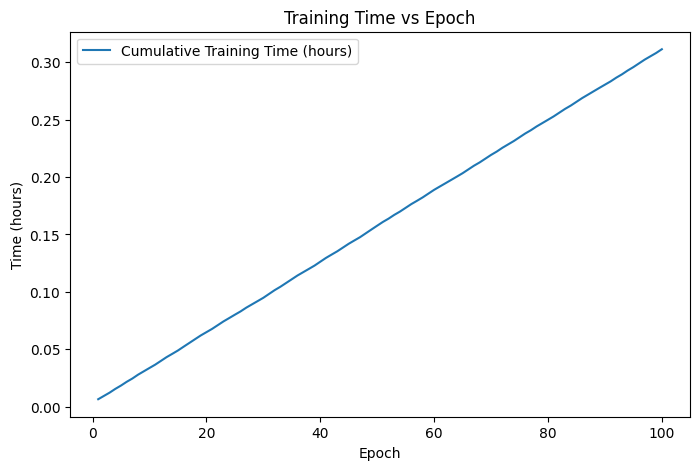

Total training time: 1136.56 seconds


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
import os
import tensorflow as tf
from skimage.metrics import structural_similarity as ssim

# Define paths
MODEL_SAVE_PATH = "/content/drive/MyDrive/Model"
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Metrics computation function
def compute_metrics(enhanced, ground_truth):
    enhanced = np.clip(enhanced, 0, 1)
    ground_truth = np.clip(ground_truth, 0, 1)
    psnr_val = psnr(ground_truth, enhanced, data_range=1.0)
    ssim_val = ssim(ground_truth, enhanced, data_range=1.0, channel_axis=-1)
    mse_val = mse(ground_truth.flatten(), enhanced.flatten())
    return psnr_val, ssim_val, mse_val

# Hybrid loss function
def hybrid_loss(y_true, y_pred):
    # Use MeanSquaredError from tf.keras.losses
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return mse_loss

# Modified training loop with model saving and metrics tracking
def train_model(model, train_low, train_high, test_low, test_high, epochs=100, batch_size=8):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'time': []}
    metrics = {'epoch': [], 'psnr': [], 'ssim': [], 'mse': []}
    start_time = time.time()

    # Select a single test image for evaluation
    test_image_idx = 0
    test_low_img = test_low[test_image_idx:test_image_idx+1]
    test_high_img = test_high[test_image_idx]

    for epoch in range(epochs):
        epoch_start = time.time()
        print(f"Epoch {epoch+1}/{epochs}")
        hist = model.fit(
            train_low, train_high,
            validation_data=(test_low, test_high),
            epochs=1,
            batch_size=batch_size,
            verbose=1
        )

        # Update history
        history['loss'].append(hist.history['loss'][0])
        history['val_loss'].append(hist.history['val_loss'][0])
        history['accuracy'].append(hist.history['accuracy'][0])
        history['val_accuracy'].append(hist.history['val_accuracy'][0])
        history['time'].append(time.time() - epoch_start)

        # Compute metrics on test image
        enhanced = model.predict(test_low_img, verbose=0)[0]
        psnr_val, ssim_val, mse_val = compute_metrics(enhanced, test_high_img)
        metrics['epoch'].append(epoch + 1)
        metrics['psnr'].append(psnr_val)
        metrics['ssim'].append(ssim_val)
        metrics['mse'].append(mse_val)

        # Save model every 5 epochs
        if (epoch + 1) % 5 == 0:
            model_path = os.path.join(MODEL_SAVE_PATH, f'hybrid_lenet_unet_epoch_{epoch+1}.keras')
            model.save(model_path)
            print(f"Model saved at {model_path}")

    total_time = time.time() - start_time

    # Calculate cumulative training time
    cumulative_time = np.cumsum(history['time'])

    # Plot cumulative training time in hours
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(cumulative_time) + 1), cumulative_time/3600, label='Cumulative Training Time (hours)')
    plt.title('Training Time vs Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (hours)')
    plt.legend()
    plt.savefig('training_time_cumulative_hours_vs_epoch.png')
    plt.show()
    plt.close()

    return history, metrics, total_time

# Main execution
print("Building model...")
model = hybrid_lenet_unet()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=hybrid_loss,
              metrics=['accuracy'])

print("Training model for 100 epochs...")
history, metrics, total_time = train_model(model, train_low, train_high, test_low, test_high, epochs=100)

print(f"Total training time: {total_time:.2f} seconds")

Low-quality image (resized) shape: (256, 256, 3)
Ground-truth image shape: (400, 600, 3)
Target size for resizing (height, width): (400, 600)
Epoch 5: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 5: PSNR=20.0116, SSIM=0.6857, MSE=0.009973, MRE=30262874.000000
Epoch 10: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 10: PSNR=18.7925, SSIM=0.7023, MSE=0.013205, MRE=29839188.000000
Epoch 15: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 15: PSNR=19.9212, SSIM=0.7176, MSE=0.010183, MRE=15141401.000000
Epoch 20: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 20: PSNR=19.6582, SSIM=0.6995, MSE=0.010819, MRE=16882338.000000


Epoch 25: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 25: PSNR=20.0414, SSIM=0.7063, MSE=0.009905, MRE=17068804.000000


Epoch 30: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 30: PSNR=21.7511, SSIM=0.7223, MSE=0.006682, MRE=15717192.000000
Epoch 35: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 35: PSNR=21.6534, SSIM=0.7180, MSE=0.006834, MRE=21566036.000000
Epoch 40: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 40: PSNR=20.7976, SSIM=0.7045, MSE=0.008322, MRE=16411851.000000
Epoch 45: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 45: PSNR=21.7907, SSIM=0.7190, MSE=0.006621, MRE=13935801.000000
Epoch 50: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 50: PSNR=20.8399, SSIM=0.7081, MSE=0.008242, MRE=20184992.000000
Epoch 55: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 600, 3)
Epoch 55: PSNR=20.7539, SSIM=0.7150, MSE=0.008406, MRE=17228668.000000
Epoch 60: Enhanced resized shape: (400, 600, 3), Ground-truth shape: (400, 6

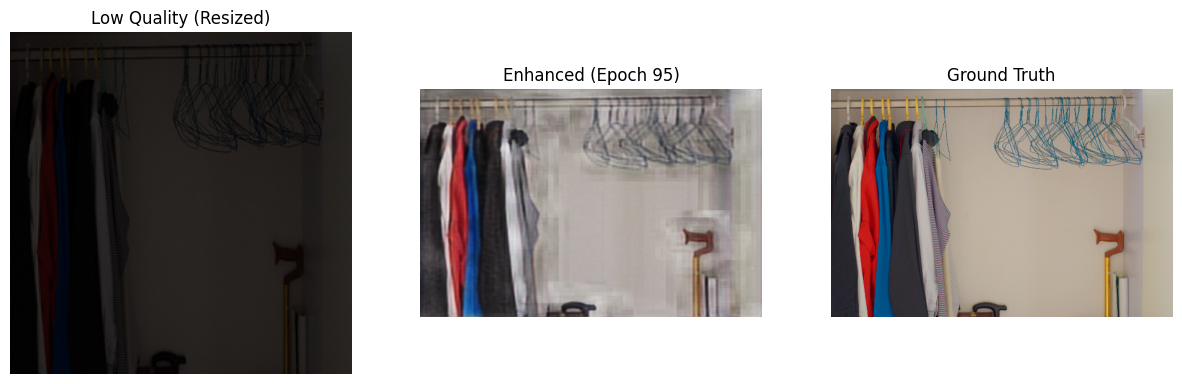

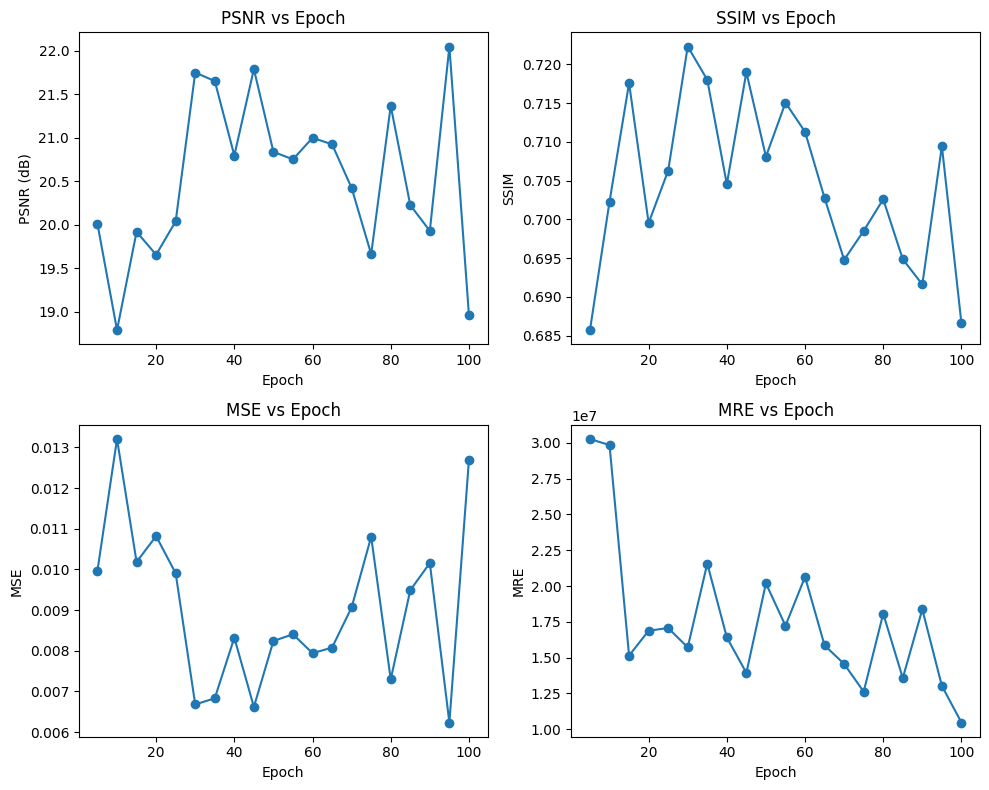

In [ ]:
import os
import numpy as np
import tensorflow as tf
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
MODEL_SAVE_PATH = "/content/drive/MyDrive/Model"
IMAGE_LOW_PATH = "/content/eval15/low/146.png"  # Eval15 low-quality image
IMAGE_HIGH_PATH = "/content/eval15/high/146.png"  # Eval15 high-quality image

# Hybrid loss function (required for loading saved models)
def hybrid_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    return mse_loss

# Load and preprocess image
def load_image(image_path, resize_to=None):
    img = Image.open(image_path).convert('RGB')
    if resize_to:
        img = img.resize(resize_to, Image.LANCZOS)  # High-quality resizing
    img = np.array(img).astype(np.float32) / 255.0  # Normalize to [0, 1]
    return img

# Resize image using TensorFlow (for enhanced image)
def resize_image(image, target_size):
    image = tf.image.resize(image, target_size, method='lanczos3')
    return image.numpy()

# Compute MRE (Mean Relative Error)
def compute_mre(enhanced, ground_truth, epsilon=1e-10):
    abs_error = np.abs(enhanced - ground_truth)
    denominator = np.abs(ground_truth) + epsilon  # Avoid division by zero
    mre_val = np.mean(abs_error / denominator)
    return mre_val

# Compute all metrics
def compute_metrics(enhanced, ground_truth):
    enhanced = np.clip(enhanced, 0, 1)
    ground_truth = np.clip(ground_truth, 0, 1)
    psnr_val = psnr(ground_truth, enhanced, data_range=1.0)
    ssim_val = ssim(ground_truth, enhanced, data_range=1.0, channel_axis=-1)
    mse_val = mse(ground_truth.flatten(), enhanced.flatten())
    mre_val = compute_mre(enhanced, ground_truth)
    return psnr_val, ssim_val, mse_val, mre_val

# Load images
model_input_size = (256, 256)  # Model expects 256x256

# Load low-quality image and resize to model input size
low_img = load_image(IMAGE_LOW_PATH, resize_to=model_input_size)
low_img_batch = np.expand_dims(low_img, axis=0)  # Shape: (1, 256, 256, 3)

# Load high-quality image (original size)
high_img = load_image(IMAGE_HIGH_PATH)  # Shape: (height, width, 3)
target_size = (high_img.shape[0], high_img.shape[1])  # (height, width)

# Debug: Print image shapes
print(f"Low-quality image (resized) shape: {low_img.shape}")
print(f"Ground-truth image shape: {high_img.shape}")
print(f"Target size for resizing (height, width): {target_size}")

# Initialize results
results = {'epoch': [], 'psnr': [], 'ssim': [], 'mse': [], 'mre': [], 'enhanced': []}
best_psnr = -float('inf')
best_result = None

# Evaluate each saved model
for epoch in range(5, 101, 5):
    model_path = os.path.join(MODEL_SAVE_PATH, f"hybrid_lenet_unet_epoch_{epoch}.keras")
    if not os.path.exists(model_path):
        print(f"Model at epoch {epoch} not found, skipping...")
        continue

    # Load model
    model = tf.keras.models.load_model(model_path, custom_objects={'hybrid_loss': hybrid_loss})

    # Generate enhanced image
    enhanced = model.predict(low_img_batch, verbose=0)[0]  # Shape: (256, 256, 3)

    # Resize enhanced image to match ground-truth size
    enhanced_resized = resize_image(enhanced, target_size)  # (height, width, 3)

    # Debug: Print shapes before metrics
    print(f"Epoch {epoch}: Enhanced resized shape: {enhanced_resized.shape}, Ground-truth shape: {high_img.shape}")

    # Compute metrics
    psnr_val, ssim_val, mse_val, mre_val = compute_metrics(enhanced_resized, high_img)

    # Store results
    results['epoch'].append(epoch)
    results['psnr'].append(psnr_val)
    results['ssim'].append(ssim_val)
    results['mse'].append(mse_val)
    results['mre'].append(mre_val)
    results['enhanced'].append(enhanced_resized)

    # Update best result
    if psnr_val > best_psnr:
        best_psnr = psnr_val
        best_result = {
            'epoch': epoch,
            'psnr': psnr_val,
            'ssim': ssim_val,
            'mse': mse_val,
            'mre': mre_val,
            'enhanced': enhanced_resized
        }

    print(f"Epoch {epoch}: PSNR={psnr_val:.4f}, SSIM={ssim_val:.4f}, MSE={mse_val:.6f}, MRE={mre_val:.6f}")

# Display best result
print("\nBest Result (based on highest PSNR):")
print(f"Epoch: {best_result['epoch']}")
print(f"PSNR: {best_result['psnr']:.4f}")
print(f"SSIM: {best_result['ssim']:.4f}")
print(f"MSE: {best_result['mse']:.6f}")
print(f"MRE: {best_result['mre']:.6f}")

# Visualize best result
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Low Quality (Resized)')
plt.imshow(low_img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title(f'Enhanced (Epoch {best_result["epoch"]})')
plt.imshow(best_result['enhanced'])
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Ground Truth')
plt.imshow(high_img)
plt.axis('off')

plt.savefig('best_enhanced_image_comparison.png')
plt.show()

# Plot metrics over epochs
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(results['epoch'], results['psnr'], marker='o')
plt.title('PSNR vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')

plt.subplot(2, 2, 2)
plt.plot(results['epoch'], results['ssim'], marker='o')
plt.title('SSIM vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('SSIM')

plt.subplot(2, 2, 3)
plt.plot(results['epoch'], results['mse'], marker='o')
plt.title('MSE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE')

plt.subplot(2, 2, 4)
plt.plot(results['epoch'], results['mre'], marker='o')
plt.title('MRE vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('MRE')

plt.tight_layout()
plt.savefig('metrics_vs_epoch.png')
plt.show()
